# Train model

Train and fine-tune a headless MobileNet V3 on a target image dataset directory

## Config

In [75]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os
from pathlib import Path
import logging
import pandas as pd
import numpy as np
import sqlalchemy as sqa
from typing import Callable
from collections import Counter
from scipy.stats import entropy
from matplotlib.ticker import StrMethodFormatter
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import json

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [88]:
# PARAMETERS
# Model Parameters
image_size = (224, 224)
batch_size = 16
dropout_rate = 0.2
shuffle_buffer = 50

epochs = {
    'top_layer': 500,
    'fine_tuning': 500
}

learning_rates = {
    'top_layer': 0.0001,
    'fine_tuning': 0.00001
}

fine_tune_unfreeze_frac = 0.3

class_weight_defaults = {
    'positive': 4,
    'negative': 1,
}

model_output_path = '../models/pipeline_v1/MNv3-xfer_binary_v1'
model_labels_path = '../models/pipeline_v1/class_labels_binary.json'


# Data parameters
db_container = "metadata_db"
db_user = "pguser"
db_password = "pgpassword"
db_port = 5432
db_database = "metadata"
db_prefix = "postgresql"

class_weights = {} # TODO use class weights

metadata_tbl = "base_images"
datasets_tbl = "datasets"
dataset_img_tbl = "dataset_images"

dataset_name = "all_v1_binary"
# dataset_name = "test_bin_example"

# Output parameters
dataset_img_path = f"../datasets/pipeline_v1/{dataset_name}_pipeline/"

In [3]:
db_con_str = f"{db_prefix}://{db_user}:{db_password}@{db_container}:{db_port}/{db_database}"
db_engine = sqa.create_engine(db_con_str)

input_shape = (*image_size, 3)

In [4]:
with db_engine.connect() as con:
    df_dataset = pd.read_sql_query(f"""
                                   SELECT * FROM {datasets_tbl}
                                   WHERE name = '{dataset_name}'
                                   """, con, index_col='name')
    df_imgs = pd.read_sql_query(f"""
                                SELECT * FROM {dataset_img_tbl}
                                LEFT JOIN {metadata_tbl} ON {dataset_img_tbl}.image_name = {metadata_tbl}.image_name
                                WHERE dataset_name = '{dataset_name}'
                                """
                                , con, index_col='image_name')
    
ds_config = df_dataset.loc[dataset_name].to_dict()
ds_config['has_test'] = ds_config['test_frac'] > 0
ds_config['has_val'] = ds_config['validation_frac'] > 0
ds_config

{'target_dir': '/home/code/datasets/pipeline_v1/all_v1_binary',
 'description': 'All images in v1 dataset with binary',
 'validation_frac': 0.2,
 'test_frac': 0.0,
 'label_method': 'BINARY',
 'has_test': False,
 'has_val': True}

In [5]:
train_dir = os.path.join(ds_config['target_dir'], 'train')
test_dir = os.path.join(ds_config['target_dir'], 'test')
val_dir = os.path.join(ds_config['target_dir'], 'validation')

## Datasets

In [6]:
def _get_image_name(img_path: str):
    """
    Convert image path to appropriate label
    """
    return(Path(img_path).name.replace("'", ""))

def label_tf_image_dataset(img_ds: tf.data.Dataset,
                           label_func: Callable[[str], str] = _get_image_name,
                           batch_size: int = batch_size) -> tf.data.Dataset:
    """
    Zips an image dataset (images, class_labels) with their image file names
    Works on unshuffled datasets & batch sizes must match
    Returns a dataset like ((images, class_labels), image_names)
    """
    img_labels = [label_func(img_path) for img_path in img_ds.file_paths]
    return tf.data.Dataset.zip((
        img_ds,
        tf.data.Dataset.from_tensor_slices(img_labels).batch(batch_size)
    ))
AUTOTUNE = tf.data.AUTOTUNE


# Make datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            label_mode='categorical')
class_names = train_dataset.class_names
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = None
if ds_config['has_val']:
    val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = None
if ds_config['has_test']:
    test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 8146 files belonging to 2 classes.
Found 2037 files belonging to 2 classes.


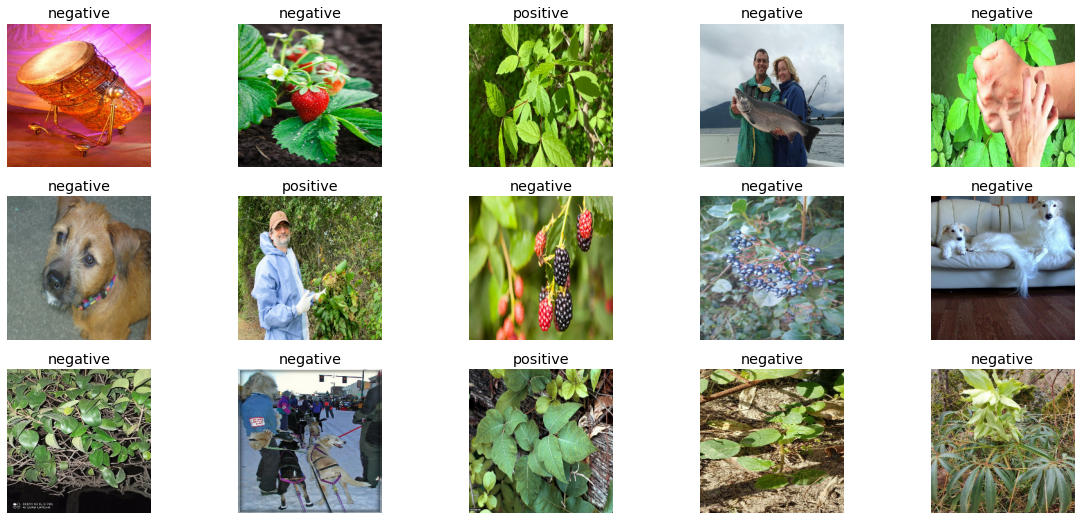

In [7]:
# TODO: fix so this takes from many class label?
n_classes = len(class_names)
y_ims = 3
x_ims = 5

plt.figure(figsize=(x_ims*4, y_ims*3))
for images, labels in train_dataset.take(1):
  for i in range(y_ims*x_ims):
    ax = plt.subplot(y_ims, x_ims, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

In [8]:
class_weights = {
    i: class_weight_defaults[class_name]
    for i, class_name in enumerate(class_names)
}
print(class_weights)

{0: 1, 1: 4}


## Processing layers

In [9]:

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


### Image augmentation

In [10]:
image_aug = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

### Mobilenet

In [11]:
mobilenet_large = MobileNetV3Large(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg',
                                   include_preprocessing=True,
                                   dropout_rate=dropout_rate)

mobilenet_large.trainable = False
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [12]:
def build_model(mobilenet):
    inputs = Input(shape=input_shape)
    x = image_aug(inputs)
    x = mobilenet(x, training=False)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    
    return(Model(inputs, outputs))
    

In [13]:
model = build_model(mobilenet_large)

In [14]:
model.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(patience=12, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(patience=4, factor=1./3.)
callbacks = [early_stopping, reduce_lr]

In [16]:
kwargs = {
    'epochs': epochs['top_layer'],
    'callbacks': callbacks
}
if ds_config['has_val']:
    kwargs['validation_data'] = val_dataset

history = model.fit(train_dataset, class_weight=class_weights, **kwargs)
print("MODEL COMPLETE")

Epoch 1/500
510/510 [==============================] - 33s 54ms/step - loss: 0.3440 - accuracy: 0.8977 - val_loss: 0.1943 - val_accuracy: 0.9411
Epoch 2/500
510/510 [==============================] - 26s 51ms/step - loss: 0.1599 - accuracy: 0.9594 - val_loss: 0.1326 - val_accuracy: 0.9568
Epoch 3/500
510/510 [==============================] - 27s 52ms/step - loss: 0.1138 - accuracy: 0.9723 - val_loss: 0.1100 - val_accuracy: 0.9656
Epoch 4/500
510/510 [==============================] - 40s 79ms/step - loss: 0.0922 - accuracy: 0.9790 - val_loss: 0.0928 - val_accuracy: 0.9745
Epoch 5/500
510/510 [==============================] - 37s 72ms/step - loss: 0.0784 - accuracy: 0.9815 - val_loss: 0.0895 - val_accuracy: 0.9725
Epoch 6/500
510/510 [==============================] - 35s 69ms/step - loss: 0.0722 - accuracy: 0.9838 - val_loss: 0.0876 - val_accuracy: 0.9735
Epoch 7/500
510/510 [==============================] - 33s 64ms/step - loss: 0.0619 - accuracy: 0.9878 - val_loss: 0.0701 - val_ac

## Fine-tune models

In [17]:
unfreeze = int(len(mobilenet_large.layers) * fine_tune_unfreeze_frac)

print(f"Mobilenet-large: Unfreezing {unfreeze} of {len(mobilenet_large.layers)} layers")
mobilenet_large.trainable = True
for layer in mobilenet_large.layers[:-unfreeze]:
    layer.trainable = False

Mobilenet-large: Unfreezing 81 of 270 layers


In [18]:
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [19]:
model.compile(optimizer=RMSprop(learning_rate=learning_rates['fine_tuning']),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
print(len(history.epoch))

37


In [21]:
base_epochs = len(history.epoch)
history_FT = model.fit(train_dataset,
                       validation_data=val_dataset,
                       epochs=epochs['fine_tuning'] + base_epochs,
                       initial_epoch=history.epoch[-1],
                       callbacks=callbacks,
                       class_weight=class_weights)

Epoch 37/537
510/510 [==============================] - 49s 84ms/step - loss: 0.0315 - accuracy: 0.9942 - val_loss: 0.0575 - val_accuracy: 0.9838
Epoch 38/537
510/510 [==============================] - 43s 83ms/step - loss: 0.0333 - accuracy: 0.9944 - val_loss: 0.0560 - val_accuracy: 0.9838
Epoch 39/537
510/510 [==============================] - 44s 86ms/step - loss: 0.0316 - accuracy: 0.9948 - val_loss: 0.0679 - val_accuracy: 0.9838
Epoch 40/537
510/510 [==============================] - 43s 85ms/step - loss: 0.0326 - accuracy: 0.9944 - val_loss: 0.0642 - val_accuracy: 0.9863
Epoch 41/537
510/510 [==============================] - 42s 83ms/step - loss: 0.0325 - accuracy: 0.9948 - val_loss: 0.0701 - val_accuracy: 0.9809
Epoch 42/537
510/510 [==============================] - 44s 86ms/step - loss: 0.0334 - accuracy: 0.9945 - val_loss: 0.0636 - val_accuracy: 0.9867
Epoch 43/537
510/510 [==============================] - 41s 80ms/step - loss: 0.0298 - accuracy: 0.9950 - val_loss: 0.0616 -

## Analyze history

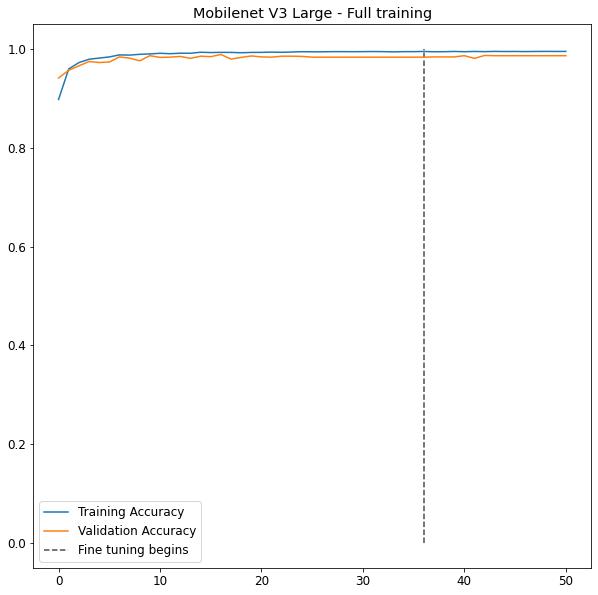

In [22]:
plt.figure(figsize=(10,10))

total_history = {}
for metric in ['accuracy', 'val_accuracy']:
    total_history[metric] = history.history[metric] + history_FT.history[metric]

ax = plt.subplot(1,1,1)
plt.plot(total_history['accuracy'], label='Training Accuracy')
plt.plot(total_history['val_accuracy'], label='Validation Accuracy')
y_min, y_max = (0, 1)
plt.vlines(base_epochs-1, ymin=y_min, ymax=y_max, label='Fine tuning begins', linestyles='--', colors=[0.3]*3)
plt.title("Mobilenet V3 Large - Full training")
plt.legend()


plt.show()

## Analyze results

In [23]:
POSITIVE = 'positive'
NEGATIVE = 'negative'
POSITIVE_IND = class_names.index(POSITIVE)

### Build results dataset

In [24]:
result_records = []
ds_splits = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
class_name_counts = Counter()

for split, dataset in ds_splits.items():
    if dataset is not None:
        for imgs, class_labels in dataset:
            probs = model.predict(imgs)
            class_values = class_labels.numpy().argmax(axis=1)
            for prob, class_val in zip(probs, class_values):
                pred = prob.argmax()
                class_name = class_names[class_val]
                class_name_counts[class_name] += 1
                img_name = class_name + '_' + str(class_name_counts[class_name])   # Count image within class to name it
                target_path = Path(Path(dataset_img_path).absolute().resolve(), img_name + '.jpg')

                record = {'ds_image_name': img_name,
                          'split': split,
                          'class_value': class_val,
                          'class_name': class_names[class_val],
                          'pred_val': pred,
                          'pred_probs': prob,
                          'pred_class': class_names[pred],
                          'is_positive': class_val == POSITIVE_IND,
                          'pred_positive': pred == POSITIVE_IND,
                          'binary_pred': POSITIVE if pred == POSITIVE_IND else NEGATIVE,
                          'binary_class': POSITIVE if class_val == POSITIVE_IND else NEGATIVE,
                          'positive_prob': prob[POSITIVE_IND],
                          'target_path': target_path}
                result_records.append(record)
df_res = pd.DataFrame(result_records).set_index('ds_image_name')
df_res['pred_entropy'] = df_res['pred_probs'].map(entropy)
del(result_records)
df_res.head()

,split,class_value,class_name,pred_val,pred_probs,pred_class,is_positive,pred_positive,binary_pred,binary_class,positive_prob,target_path,pred_entropy
ds_image_name,,,,,,,,,,,,,
negative_1,train,0,negative,0,"[0.9999759, 2.4031895e-05]",negative,False,False,negative,negative,2.403190e-05,/home/code/datasets/pipeline_v1/all_v1_binary_...,2.796267e-04
negative_2,train,0,negative,0,"[0.9999361, 6.3886866e-05]",negative,False,False,negative,negative,6.388687e-05,/home/code/datasets/pipeline_v1/all_v1_binary_...,6.809388e-04
negative_3,train,0,negative,0,"[1.0, 3.5057843e-10]",negative,False,False,negative,negative,3.505784e-10,/home/code/datasets/pipeline_v1/all_v1_binary_...,7.632596e-09
negative_4,train,0,negative,0,"[0.9999738, 2.617918e-05]",negative,False,False,negative,negative,2.617918e-05,/home/code/datasets/pipeline_v1/all_v1_binary_...,3.023708e-04
negative_5,train,0,negative,0,"[1.0, 1.4285428e-08]",negative,False,False,negative,negative,1.428543e-08,/home/code/datasets/pipeline_v1/all_v1_binary_...,2.580524e-07


In [25]:
conf_matrix = (
    df_res.groupby(['split', 'class_name', 'pred_class'])['class_value']
        .count()
        .reset_index()
        .rename({'class_value': 'counts'}, axis=1)
        .pivot(index=['split', 'class_name'], columns='pred_class', values='counts')
        .fillna(0)
        .astype('int')
)

conf_matrix

pred_class        negative  positive
split class_name                    
train negative        6590        37
      positive          27      1492
val   negative        1636        21
      positive           7       373

In [26]:
split_sums = conf_matrix.groupby('split').sum().sum(axis=1)
conf_mat_frac = conf_matrix.apply(
    lambda col: pd.DataFrame(col).apply(
        lambda row: row.iloc[0] / split_sums[row.name[0]],
    axis=1), 
axis=0)
conf_mat_frac

pred_class        negative  positive
split class_name                    
train negative    0.808986  0.004542
      positive    0.003315  0.183157
val   negative    0.803142  0.010309
      positive    0.003436  0.183112

In [27]:
## FROM MATPLOTLIB DOCS: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", include_cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if include_cbar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for spine in ['left', 'right', 'top', 'bottom']:
        ax.spines[spine].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

<class 'matplotlib.axes._subplots.AxesSubplot'>


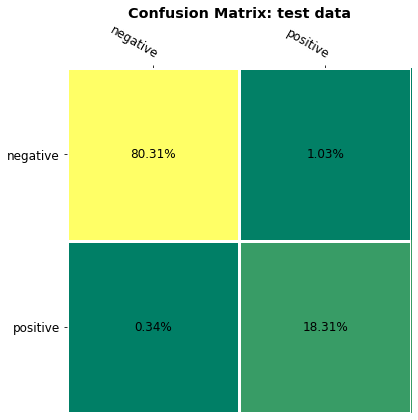

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
cm_plot = conf_mat_frac.loc['val']
print(type(ax))
im = heatmap(cm_plot, cm_plot.index, cm_plot.columns, ax=ax, include_cbar=False, cmap="summer")
texts = annotate_heatmap(im, valfmt="{x:.2%}")
ax.set_title(f"Confusion Matrix: {split} data", fontweight='bold')
fig.tight_layout()
plt.show()

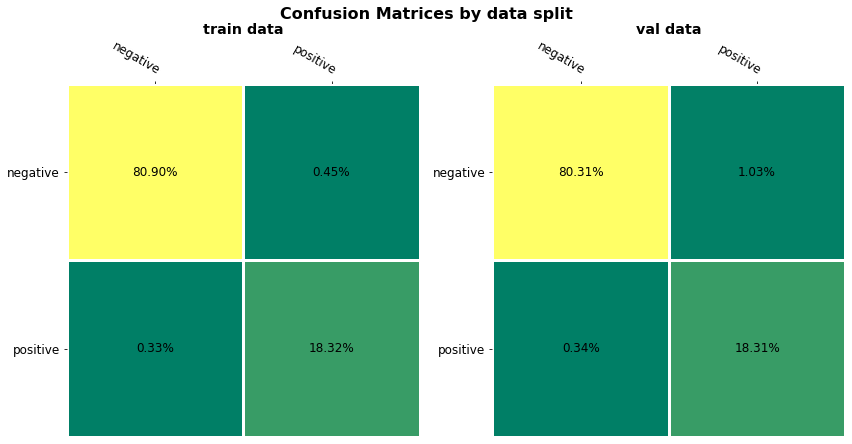

In [29]:
n_splits = df_res['split'].nunique()
fig = plt.figure(figsize=(6*n_splits,8))

for i, split in enumerate(df_res['split'].unique()):
    n_split = i+1
    ax = plt.subplot(1, n_splits, n_split)
    cm_plot = conf_mat_frac.loc[split]
    im = heatmap(cm_plot, cm_plot.index, cm_plot.columns, ax=ax, include_cbar=False, cmap="summer")
    texts = annotate_heatmap(im, valfmt="{x:.2%}")
    ax.set_title(f"{split} data", fontweight='bold')

# fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 1.05])
fig.suptitle("Confusion Matrices by data split\n", fontsize=16, fontweight='bold')
# plt.subplots_adjust(top=0.8)
plt.show()

In [31]:
conf_matrix_binary = (
    df_res.groupby(['split', 'binary_class', 'binary_pred'])['class_value']
        .count()
        .reset_index()
        .rename({'class_value': 'counts'}, axis=1)
        .pivot(index=['split', 'binary_class'], columns='binary_pred', values='counts')
        .fillna(0)
        .astype('int')
)
conf_matrix_binary

binary_pred         negative  positive
split binary_class                    
train negative          6590        37
      positive            27      1492
val   negative          1636        21
      positive             7       373

In [32]:
split_sums_bin = conf_matrix_binary.groupby('split').sum().sum(axis=1)
conf_mat_bin_frac = conf_matrix_binary.apply(
    lambda col: pd.DataFrame(col).apply(
        lambda row: row.iloc[0] / split_sums_bin[row.name[0]],
    axis=1), 
axis=0)
conf_mat_bin_frac

binary_pred         negative  positive
split binary_class                    
train negative      0.808986  0.004542
      positive      0.003315  0.183157
val   negative      0.803142  0.010309
      positive      0.003436  0.183112

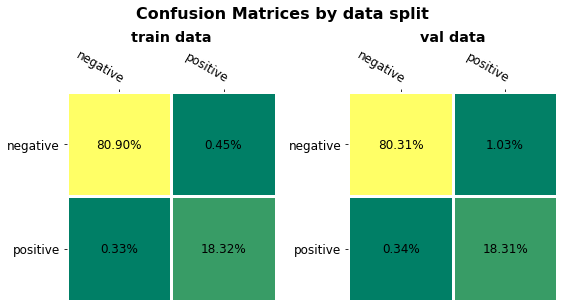

In [45]:
n_splits = df_res['split'].nunique()
fig = plt.figure(figsize=(4*n_splits,6))

for i, split in enumerate(df_res['split'].unique()):
    n_split = i+1
    ax = plt.subplot(1, n_splits, n_split)
    cm_plot = conf_mat_bin_frac.loc[split]
    im = heatmap(cm_plot, cm_plot.index, cm_plot.columns, ax=ax, include_cbar=False, cmap="summer")
    texts = annotate_heatmap(im, valfmt="{x:.2%}")
    ax.set_title(f"{split} data", fontweight='bold')

# fig.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 1.05])
fig.suptitle("Confusion Matrices by data split\n", fontsize=16, fontweight='bold')
# plt.subplots_adjust(top=0.8)
plt.show()

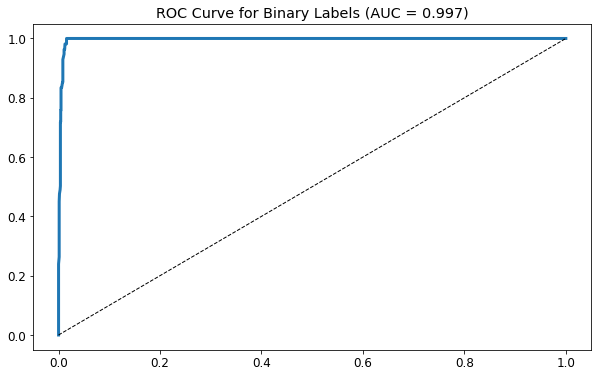

In [93]:
df_plot = df_res[df_res['split'] == 'val']
fpr, tpr, thresholds = roc_curve(df_plot['binary_class'].map({NEGATIVE: 0, POSITIVE: 1}), df_plot['positive_prob'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.title(f"ROC Curve for Binary Labels (AUC = {roc_auc:.3f})")
plt.plot(fpr, tpr, linewidth=3)
plt.plot(np.linspace(0,1), np.linspace(0,1), color='black', linestyle='--', linewidth=1)
plt.show()

## Store model

In [89]:
Path(model_output_path).parents[0].mkdir(exist_ok=True, parents=True)

In [90]:
model.save(model_output_path)

INFO:tensorflow:Assets written to: ../models/pipeline_v1/MNv3-xfer_binary_v1/assets


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [91]:
with open(model_labels_path, 'w') as f:
    json.dump({i: cn for i, cn in enumerate(class_names)}, f)